<hr style="height: 4px; color: #839D2D; width: 100%; ">  
<balise id="home">  </balise> 
    
# <font color='#61210B'>Formation OpenClassRooms   -   Parcours DATA ANALYST</font>

<hr style="height: 2px; color: #839D2D; width: 100%; ">

## <font color='#38610B'>Projet IV - Analysez les ventes de votre entreprise</font>
<u>Mise en situation</u>  
Vous êtes Data Analyst d'une grande chaîne de librairie, fraîchement embauché depuis une semaine !  
Le service informatique vous a donné l’accès à la base de données des ventes. A vous de vous familiariser avec les données, et de les analyser. Votre manager souhaite que vous réalisiez une présentation pour vous "faire la main".  

### Mission 3 - Corrélations
- <a href="#par31">Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetés ? </a>


- Y a-t-il une corrélation entre l'âge des clients et :  
    - <a href="#par321">le montant total des achats  </a>
    - <a href="#par322">la fréquence d’achat (ie. nombre d'achats par mois par exemple)  </a>
    - <a href="#par323">la taille du panier moyen (en nombre d’articles)  </a>
    - <a href="#par324">les catégories de produits achetés  </a>


<b><font color='#38610B'>- Date : 31 Jan 2019</font></b>  

Auteur : Frédéric Boissy
<hr style="height: 4px; color: #839D2D; width: 100%; ">


#####   <font color='#013ADF'>ENVIRONNEMENT DE TRAVAIL :</font> Définition - Initialisation

In [1]:
# -*- coding: utf8 -*-
import numpy as np
import pandas as pd
#pd.options.display.float_format = '{:,.2f}'.format   # Nombres avec sepa milliers "," et 2décimales après "."
pd.options.mode.use_inf_as_na = True

import seaborn as sns
import matplotlib as matplt
import matplotlib.pyplot as plt
from matplotlib import patches

import scipy as sc
import scipy.stats as st
import statsmodels.api as sm

from IPython.display import display, Markdown, HTML  # pour gérer un affichage plus joli que la fonction "print"

import time   # Librairie temps pour calculs durée par exemple
trt_start_time = time.time()

In [2]:
# Pour executer des requetes SQL de verification sur des DF
import pandasql as pdsql
from pandasql import sqldf
execsql = lambda q: sqldf(q, globals())   
# req1 = ''' Select zone1, zone2 From DataFrame Where zone3=xx and zone4='xx' limit 3;'''
# df1 = execsql(req1)
# df1

#####   <font color='#013ADF'>REPERTOIRE DE TRAVAIL :</font> (du Projet)
Par defaut on utilisera celui dans lequel se trouve ce fichier jupyter

In [3]:
%cd OUTFILES

D:\DATA_ANALYST\WORK\#GITHUB\PJ4\OUTFILES


#####   <font color='#013ADF'>CHARGEMENT DATA "csv" :</font> après nettoyage des donnés dans un Dataframe enrichi

In [4]:
#sal = pd.read_csv("DATA/sales.csv")
sal = pd.read_csv("m3_sales_sans_outliers_avec_imput_ref.zip")
cst = pd.read_csv("cst.csv")
prd = pd.read_csv("prd.csv")
# On supprime les lignes contenant au moins une valeur manquante
sal = sal.dropna(axis=0, how='any')
sal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306303 entries, 0 to 306302
Data columns (total 14 columns):
session_id      306303 non-null object
client          306303 non-null object
sex             306303 non-null object
age             306303 non-null int64
birthyear       306303 non-null int64
prod            306303 non-null object
price           306303 non-null float64
categ           306303 non-null int64
period          306303 non-null object
year            306303 non-null int64
month           306303 non-null int64
day             306303 non-null int64
time            306303 non-null object
session_date    306303 non-null object
dtypes: float64(1), int64(6), object(7)
memory usage: 35.1+ MB


In [5]:
%cd ..

D:\DATA_ANALYST\WORK\#GITHUB\PJ4


##  <font color='purple'>Les OUTLIERS (Gros Clients) et (Age=18ans) ne sont pas pris en compte</font>  
> <font color='purple'>AFIN DE NE PAS FAUSSER LES RESULTATS</font>  
Fichier csv spécifique Mission 3 préparé dans le notebook Mission 1 - DataCleaning

### Ajout d'une Colonne "Tranche d'ages" pour étude

In [6]:
liste_tranches = [18, 30, 50, 100]
nom_tranches = ["19-30","31-50","51+"]
sal['tranche'] = pd.cut(sal.age, liste_tranches, labels = nom_tranches)
cols = ['session_id', 'client', 'sex', 'birthyear', 'age', 'tranche', 'prod', 'price', 'categ', 'period', 
        'year', 'month', 'day', 'time', 'session_date']
sal = sal[cols]
sal.head()

,session_id,client,sex,birthyear,age,tranche,prod,price,categ,period,year,month,day,time,session_date
0,s_18746,c_4450,f,1977,45,31-50,0_1483,4.99,0,2021-04,2021,4,10,18:37,2021-04-10 18:37:28.723910
1,s_140787,c_5433,f,1981,41,31-50,0_1483,4.99,0,2021-12,2021,12,27,11:11,2021-12-27 11:11:12.123067
2,s_110736,c_857,m,1985,37,31-50,0_1483,4.99,0,2021-10,2021,10,27,04:56,2021-10-27 04:56:38.293970
3,s_57626,c_3679,f,1989,33,31-50,0_1483,4.99,0,2021-07,2021,7,4,06:43,2021-07-04 06:43:45.676567
4,s_118789,c_868,m,1975,47,31-50,0_1483,4.99,0,2021-11,2021,11,13,02:04,2021-11-13 02:04:21.760392


<hr style="height: 3px; color: #839D2D; width: 100%; ">

#  <font color='#61210B'><u>Mission n°3</u></font> : Etude de Corrélations


## <balise id="par31"><font color='darkblue'>ETUDE 3.1</balise>  <a href="#home">(↑)</a>    

<hr style="height: 1px; color: #839D2D; width: 100%; ">

### <font color='#61210B'>Corrélation entre le sexe des clients et : </font> les catégories de produits achetés

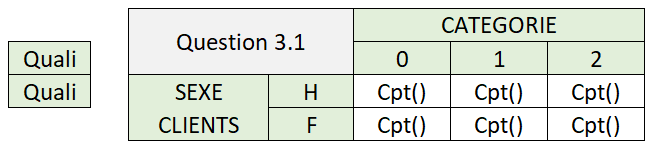

### <u>On appliquera un TEST de</u> <strong>χ2</strong>  <a href="https://fr.wikipedia.org/wiki/Test_du_%CF%87%C2%B2">(Source Wiki)</a>

Le teste du χ2 (khi2, prononcer « khi-deux » ou « khi carré », qu'on écrit également à l'anglaise « chi-deux » ou « chi carré ») <strong>permet</strong> :  
- partant d'une hypothèse (<strong>H0</strong>)  
- et d'un risque supposé au départ (<strong>α</strong>)

de <strong>rejeter l'hypothèse si</strong> la distance entre deux ensembles d'informations est jugée excessive.   
Un test d'indépendance porte sur des <strong>données qualitatives</strong>. 

<strong><font color='darkblue'>Hypothèse Nulle (H0) : la catégorie de produits achetée n'est liée au sexe des clients</font> </strong>  
   
Seuil de Tolérance/Risque choisi : <strong>α = 5%</strong> sous l'hypothèse nulle.  

Par opposition, définissons : <strong>H1, hypothèse alternative </strong>, la catégorie de produits achetée et le sexe des clients sont liés (dépendants)

#### <font color='darkred'>Création d'un Tableau de Contingence pour Calcul du χ2 (khi^2)

In [7]:
df1 = sal[['sex', 'categ', 'client']].copy()
df1 = df1.pivot_table(index=['sex'], columns=['categ'], values=['client'], aggfunc='count').reset_index()
df1.columns = ['Sexe', 'Cat_0_Reel', 'Cat_1_Reel', 'Cat_2_Reel']
df1.columns = ['Sexe', 'Cat_0_Reel', 'Cat_1_Reel', 'Cat_2_Reel']
df1['Tot_Cat_Reel'] = df1['Cat_0_Reel'] + df1['Cat_1_Reel'] + df1['Cat_2_Reel']
tot_gen = df1['Cat_0_Reel'].sum() + df1['Cat_1_Reel'].sum() + df1['Cat_2_Reel'].sum()
ligne_total = ['total', df1['Cat_0_Reel'].sum(), df1['Cat_1_Reel'].sum(), df1['Cat_2_Reel'].sum(), tot_gen]
df1.loc[len(df1)] = ligne_total
df1.head()

,Sexe,Cat_0_Reel,Cat_1_Reel,Cat_2_Reel,Tot_Cat_Reel
0,f,100279,52359,6630,159268
1,m,93323,47507,6205,147035
2,total,193602,99866,12835,306303


#### <font color='darkred'>Calcul du χ2  (khi^2)

L'hypothèse nulle revient à considérer la colonne Total par catégorie et non pas les valeurs spécifiques de chaque Catégorie.  
On renomme les colonnes du dataframe et on calcule les nouvelles colonnes "Attendues" basées sur le Ratio du Total_Categ

In [8]:
Ratio_f = df1.loc[0]['Tot_Cat_Reel'] / df1.loc[2]['Tot_Cat_Reel']
Ratio_m = df1.loc[1]['Tot_Cat_Reel'] / df1.loc[2]['Tot_Cat_Reel']
df1['Ratio_Tot'] = [Ratio_f,Ratio_m,0]
df1['Cat_0_Att'] = df1.loc[2]['Cat_0_Reel'] * df1['Ratio_Tot']
df1['Cat_1_Att'] = df1.loc[2]['Cat_1_Reel'] * df1['Ratio_Tot']
df1['Cat_2_Att'] = df1.loc[2]['Cat_2_Reel'] * df1['Ratio_Tot']
decimals = pd.Series([4, 0, 0, 0], index=['Ratio_Tot', 'Cat_0_Att', 'Cat_1_Att', 'Cat_2_Att'])
df1 = df1.round(decimals)
df1.head()

,Sexe,Cat_0_Reel,Cat_1_Reel,Cat_2_Reel,Tot_Cat_Reel,Ratio_Tot,Cat_0_Att,Cat_1_Att,Cat_2_Att
0,f,100279,52359,6630,159268,0.52,100667.0,51927.0,6674.0
1,m,93323,47507,6205,147035,0.48,92935.0,47939.0,6161.0
2,total,193602,99866,12835,306303,0.00,0.0,0.0,0.0


Carrés des ecarts de la valeur observée à la valeur attendue, divisé par la valeur attendue

In [9]:
df1['Khi2_Cat0'] = (df1['Cat_0_Reel'] - df1['Cat_0_Att'])**2 / df1['Cat_0_Att']
df1['Khi2_Cat1'] = (df1['Cat_1_Reel'] - df1['Cat_1_Att'])**2 / df1['Cat_1_Att']
df1['Khi2_Cat2'] = (df1['Cat_2_Reel'] - df1['Cat_2_Att'])**2 / df1['Cat_2_Att']
df1 = df1.fillna(0)

χ2 = somme des carrés (précédents)

In [10]:
χ2 = df1['Khi2_Cat0'].sum() + df1['Khi2_Cat1'].sum() + df1['Khi2_Cat2'].sum()
Markdown('{}<strong>{}</strong>'.format(" La valeur du χ2 est : ", round(χ2, 3)))

 La valeur du χ2 est : <strong>11.207</strong>

<strong><font color='darkblue'>Valeur Seuil et pValue </font> </strong> - Comparaison avec Abaque des Valeurs du χ2
   
Avec un Degrés de Liberté : <strong>DDL = 2</strong>   
Calcul du DDL => (Nb lignes - 1) * (nb colonnes - 1) 

<p style="text-align:center";><font color='#38610B'><u>Table des Valeurs du χ2</u></p>
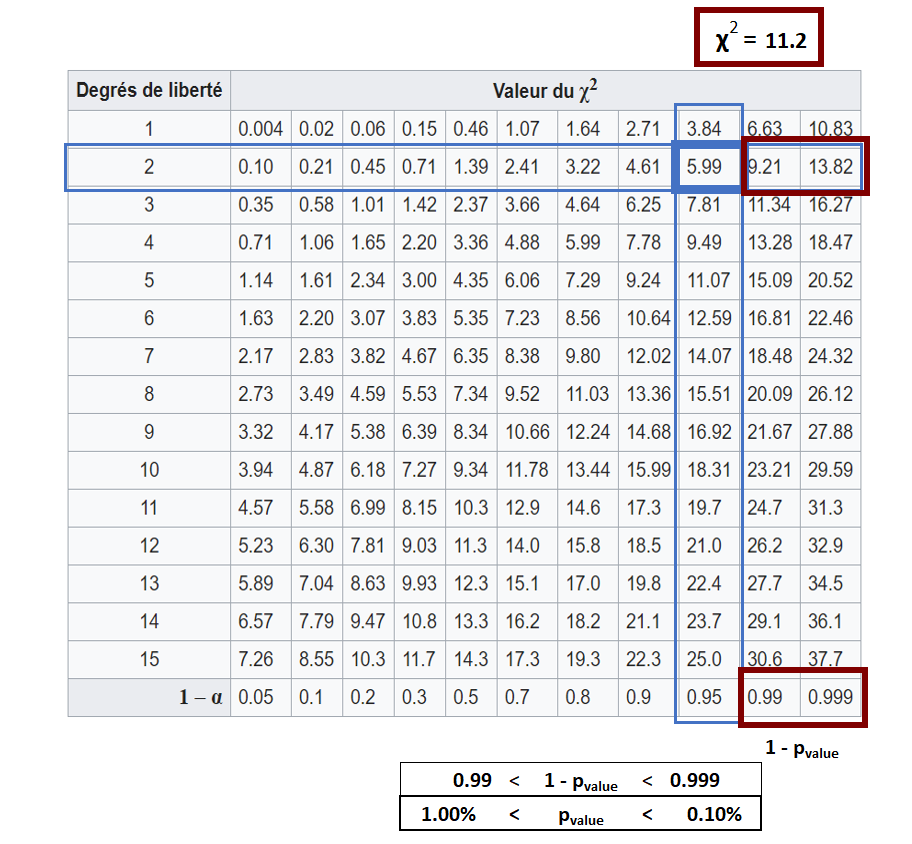

Pour valider notre hypothèse de départ (H0) il faut que notre valeur calculé du X2 soit inférieure ou egale à la valeur seuil dans le tableau ci-dessus au croisement de notre Taux de risque (x) accepté et du DDL de notre etude.  

Ici <strong>Valeur Seuil = 5.99</strong>  

11.207 est nettement supérieur à cette valeur.  
<strong>La probabilité (pvalue) pour que l'hypothèse H0 se réalise est comprise entre 0.10% et 1% !!!  
    L'hypothèse (H0) est donc à rejeter   
    
### <u><font color='darkblue'>CONCLUSION :</font></u>
### <font color='darkblue'>La variable "sexe des clients" est statisquement liée à la variable "catégorie de produits" achetés</strong></font>

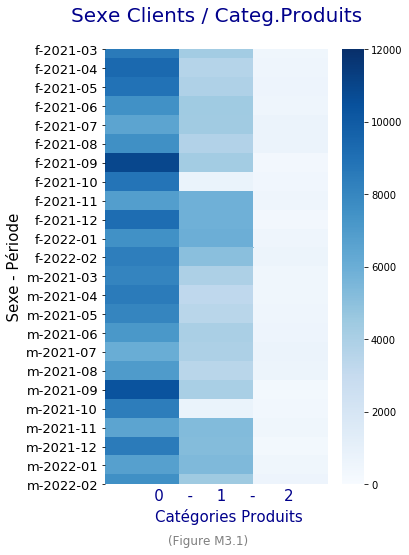

session_id           
categ                0     1    2
sex period                       
f   2021-03       8622  4337  487
    2021-04       9346  3624  562
    2021-05       8945  3882  636
    2021-06       7501  4409  609
    2021-07       6529  4360  737

In [11]:
df31 = sal[['sex', 'period', 'categ', 'session_id']].copy()
df31 = df31.pivot_table(index=['sex', 'period'], 
                        columns=['categ'], 
                        values=['session_id'], aggfunc='count')
plt.figure(figsize=(5,8))
plt.title("Sexe Clients / Categ.Produits", fontsize=20, color='darkblue', y=1.05)
ax = sns.heatmap(df31, vmin=0, vmax=12000, cmap="Blues") 
plt.xticks([])
plt.figtext(0.265, 0.06, "Catégories Produits", color="darkblue", size=15)
plt.xlabel("   0     -     1     -      2", color="darkblue", size=15)
plt.yticks(size=13)
plt.ylabel("  Sexe - Période  ", color="black", size=15)

plt.figtext(0.3,0.02,'(Figure M3.1)', fontsize=12, color = 'gray')
plt.savefig('GRAPHS/figure_M31.png', dpi=100, bbox_inches='tight')

plt.show()

plt.close()
df31.head()

<hr style="height: 3px; color: #839D2D; width: 100%; ">

## <balise id="par321"><font color='darkblue'>ETUDE 3.2</balise>  <a href="#home">(↑)</a>

<hr style="height: 1px; color: #839D2D; width: 100%; ">

### <font color='#61210B'>(3.2.1) Corrélation entre l'âge des clients et : </font> le montant total des achats

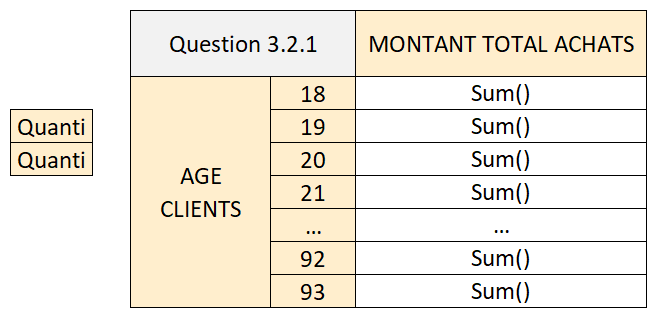

###  <font color='darkblue'>Utilisation de Coefficient de corrélation linéaire :</font> Calcul et Interprétation


<p style="text-align:center";><b><u>Formule</u></b></p>
    
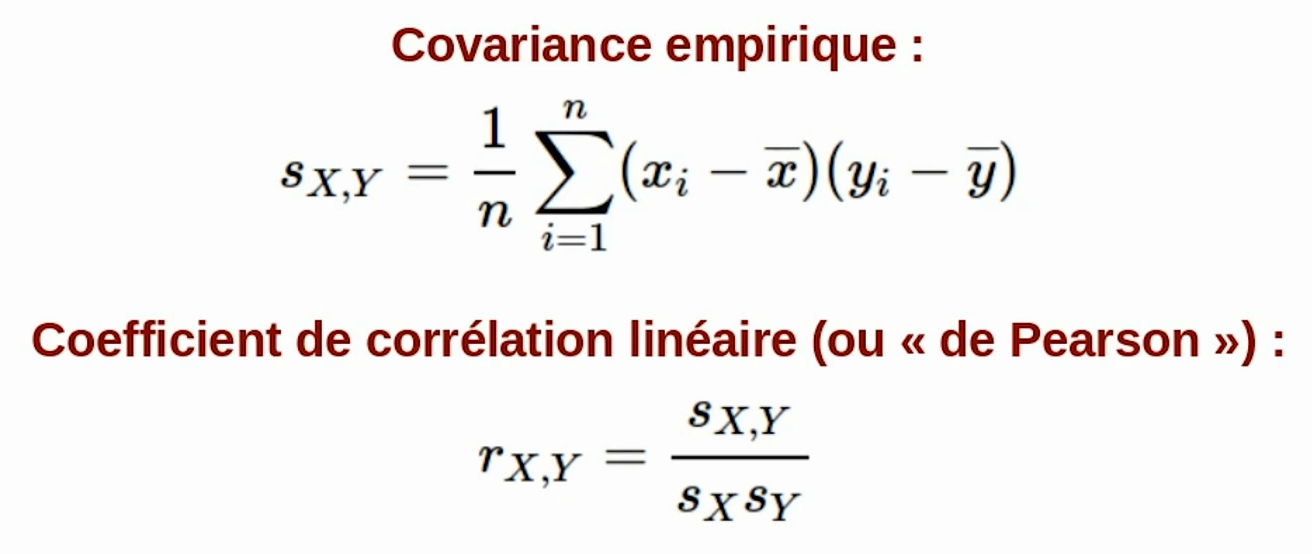

- <strong>Résistance</strong>  
    Le <strong>coefficient de corrélation</strong> peut avoir une valeur comprise entre <strong>-1 et +1</strong>. Plus la valeur absolue du coefficient est importante, plus la relation linéaire entre les variables est forte.
    Pour la corrélation de Pearson, <strong>une valeur absolue de 1</strong> indique une relation linéaire <strong>parfaite</strong>. Une corrélation proche de 0 indique l'absence de relation linéaire entre les variables.
    
    
- <strong>Sens</strong>  
    Le <strong>signe</strong> du coefficient indique la <strong>direction de la relation</strong>. Si les deux variables ont tendance à augmenter ou à diminuer ensemble, le coefficient est positif, et la ligne qui représente la corrélation s'incline vers le haut. Si une variable a tendance à augmenter lorsque l'autre diminue, le coefficient est négatif, et la ligne représentant la corrélation s'incline vers le bas.


#### <font color='darkred'>Constitution d'un Dataframe pour analyser les deux variables  

In [12]:
# df321 = sal.groupby(['age', 'sex'])['price'].sum().reset_index()
df321 = sal.groupby(['age'])['price'].sum().reset_index()
df321.head()

,age,price
0,19,88461.39
1,20,89920.34
2,21,84881.48
3,22,80110.24
4,23,96515.12


<p style="text-align:center";><u>Formule</u></p>  

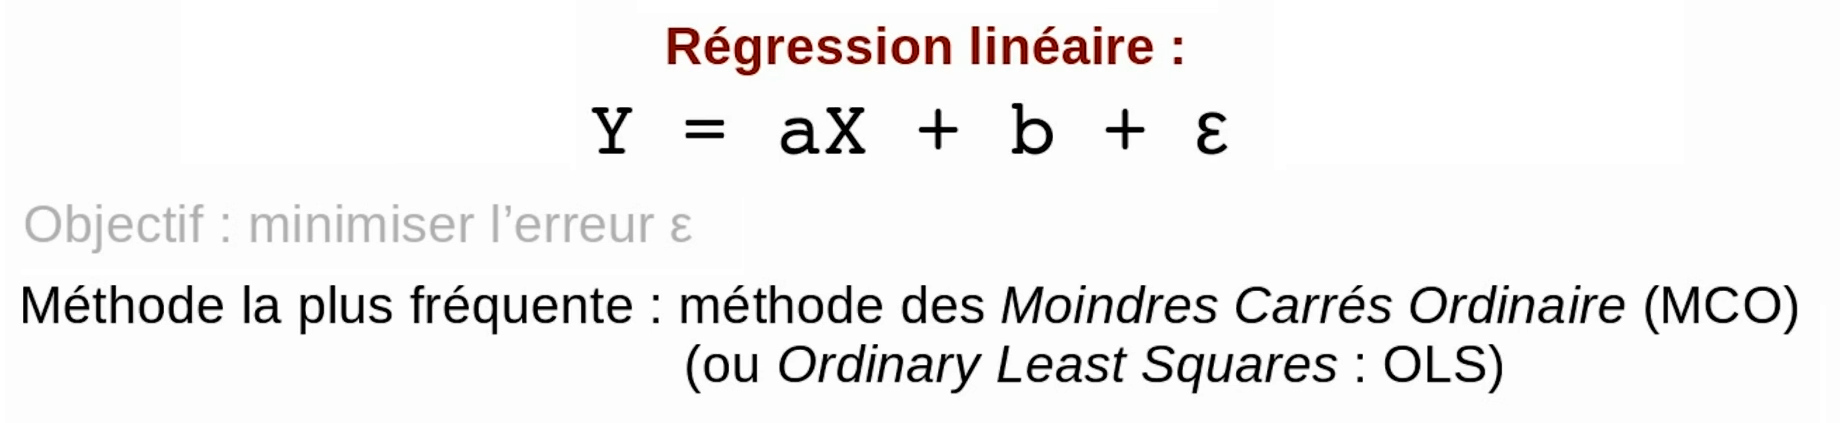

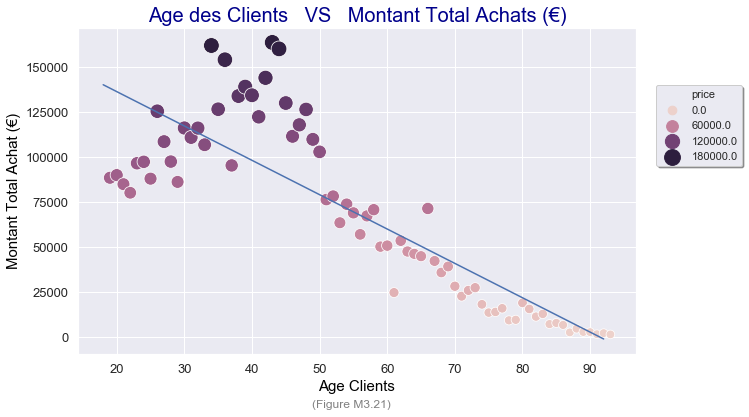

In [13]:
# Calcul de la droite de régression linéaire
X = df321[['age']]
Y = df321['price']
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['age'],result.params['intercept']
sns.set()
plt.figure(figsize=(10,6))
plt.title("Age des Clients   VS   Montant Total Achats (€)", fontsize=20, color='darkblue')

###  SCATTERPLOT 
ax = sns.scatterplot(x=df321['age'], y=df321['price'], 
                size='price', hue='price', sizes=(75, 250), data=df321)  # palette="Set3"
ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.7), ncol=1, shadow=True)

plt.xlabel("Age")
plt.xlabel("Age Clients", color="black", size=15)
plt.xticks(size=13)
plt.ylabel("Montant Total Achat (€)", color="black", size=15)
plt.yticks(size=13)


###  DROITE Régression linéaire
plt.plot(np.arange(18,93),[a*x+b for x in np.arange(18,93)])

plt.figtext(0.45,0,'(Figure M3.21)', fontsize=12, color = 'gray')
plt.savefig('GRAPHS/figure_M321.png', dpi=100, bbox_inches='tight')

plt.show()
plt.close()

In [14]:
df = sal.groupby(['client', 'age'])['price'].sum().reset_index()
df = df.sort_values(['price'], ascending=False).head(5)
df

,client,age,price
7326,c_7959,48,2564.25
7394,c_8026,44,2547.99
3684,c_4491,38,2540.53
1197,c_2140,45,2527.01
7777,c_8392,44,2515.98


- <strong>Soit la variable "r321"</strong> = coeff.correlation de "age des clients" en fonction de "montant total achats"  

Nous allons utiliser la fonction scipy.stats.pearsonr de la bibliothèque Scipy-Stats.  
Et recupérer le premier paramètre [0] de cette fonction qui correspond au coeff. de corrélation


In [15]:
r321 = st.pearsonr(df321["age"],df321["price"])[0]
round(r321, 3)

-0.85

- Les données sont donc assez corrélées, surtout à partir de l'age de 30ans environ du fait de la valeur du coefficient <b>r321</b> proche de <b>-1</b>.
> **r321 = -0.85**

Clairement sur la figure 3.21 on peut voir l'expression d'une régression linéaire sous la forme d'une droite descendante plus l'age avance.  
<b>Ainsi le signe négatif du coefficient nous confirme que quand l'age augmente, le montant total des achats diminue.</b>
    

<hr style="height: 1px; color: #839D2D; width: 100%; ">
<balise id="par322"> </balise>  

### <font color='#61210B'>(3.2.2) Corrélation entre l'âge des clients et : </font> la fréquence d’achat (ie. nombre d'achats par mois par exemple)<a href="#home">(↑)</a>    

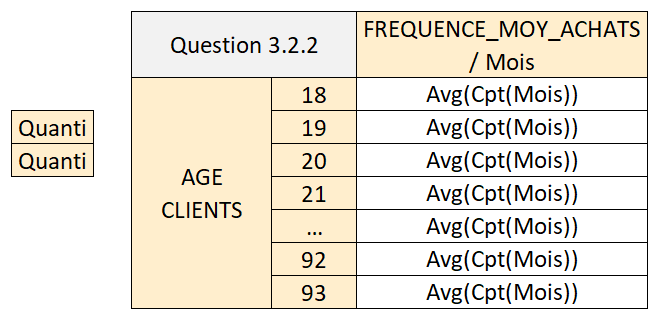

###  <font color='darkblue'>Utilisation de Coefficient de corrélation linéaire :</font>   Formule de Calcul et Interprétation  

Voir cas précédent (3.2.1)  pour principe de fonctionnement et règles.

#### <font color='darkred'>Constitution d'un Dataframe pour analyser les deux variables</font>

In [16]:
df322 = sal.pivot_table(index=['age', 'tranche'], columns=['period'], 
                        values=['price'], aggfunc="count").reset_index()
df322.columns = ['age', 'tranche', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08',
                       '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02']
df322['Freq_Moy_Mois'] = round(df322.iloc[:, [1,2,3,4,5,6,7,8,9,10,11,12]].mean(axis=1))
df322.head()

C:\Users\boiss\Anaconda3\lib\site-packages\pandas\core\dtypes\missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())


,age,tranche,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,Freq_Moy_Mois
0,19,19-30,207.0,175.0,178.0,164.0,253.0,206.0,150.0,133.0,175.0,138.0,191.0,212.0,179.0
1,20,19-30,136.0,207.0,185.0,258.0,209.0,186.0,180.0,119.0,196.0,156.0,182.0,210.0,183.0
2,21,19-30,170.0,173.0,152.0,140.0,195.0,202.0,144.0,91.0,217.0,172.0,177.0,199.0,167.0
3,22,19-30,187.0,192.0,152.0,186.0,193.0,191.0,121.0,116.0,230.0,173.0,224.0,210.0,179.0
4,23,19-30,198.0,172.0,216.0,194.0,250.0,199.0,188.0,117.0,241.0,234.0,210.0,218.0,202.0


In [17]:
df322gen = df322[['age', 'Freq_Moy_Mois']]
df322gen.head()

,age,Freq_Moy_Mois
0,19,179.0
1,20,183.0
2,21,167.0
3,22,179.0
4,23,202.0


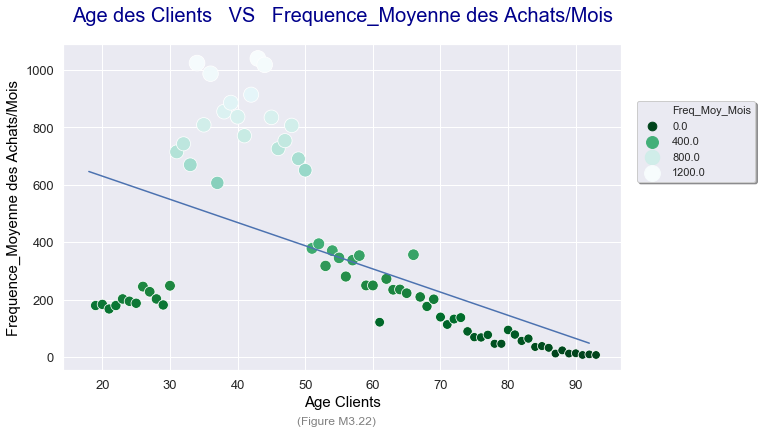

In [18]:
# Calcul de la droite de régression linéaire
X = df322gen[['age']]
Y = df322gen['Freq_Moy_Mois']
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['age'],result.params['intercept']

sns.set()
plt.figure(figsize=(10,6))
plt.title("Age des Clients   VS   Frequence_Moyenne des Achats/Mois", fontsize=20, color='darkblue', y=1.05)

###  SCATTERPLOT 
ax = sns.scatterplot(x=df322gen['age'], y=df322gen['Freq_Moy_Mois'], 
                size='Freq_Moy_Mois', hue='Freq_Moy_Mois', sizes=(75, 250), palette="BuGn_r", data=df322gen)
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.7), ncol=1, shadow=True)

plt.xlabel("Age")
plt.xlabel("Age Clients", color="black", size=15)
plt.xticks(size=13)
plt.ylabel("Frequence_Moyenne des Achats/Mois", color="black", size=15)
plt.yticks(size=13)


###  DROITE Régression linéaire
plt.plot(np.arange(18,93),[a*x+b for x in np.arange(18,93)])

plt.figtext(0.45,0,'(Figure M3.22)', fontsize=12, color = 'gray')
plt.savefig('GRAPHS/figure_M322.png', dpi=100, bbox_inches='tight')

plt.show()
plt.close()

In [19]:
r322 = st.pearsonr(df322['age'],df322['Freq_Moy_Mois'])[0]
round(r322, 3)

-0.563

- Les données sont ne sont corrélées qu'à partir de l'age de 50ans environ du fait de la valeur du coefficient <b>r321</b> proche de <b>-1</b>.
> **r322 = -0.563**

Clairement sur la figure 3.22 on constate l'expression d'une régression linéaire sous la forme d'une droite descendante après 50ans.  
<b>Ainsi le signe négatif du coefficient nous confirme que quand l'age augmente, la fréquence moyenne mensuelle des achats diminue.</b>
    

#### Split en 3 tranches d'age pour observation :
- 18-30ans
- 31-50ans
- 51+

In [20]:
df322a = df322[df322['tranche']=='19-30'][['age', 'Freq_Moy_Mois']]
df322b = df322[df322['tranche']=='31-50'][['age', 'Freq_Moy_Mois']]
df322c = df322[df322['tranche']=='51+'][['age', 'Freq_Moy_Mois']]

- Tranche 18-30 ans

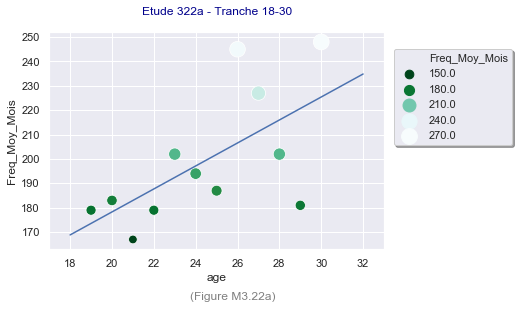

In [21]:
r322a = st.pearsonr(df322a['age'],df322a['Freq_Moy_Mois'])[0]
round(r322a, 3)

# Calcul de la droite de régression linéaire
X = df322a[['age']]
Y = df322a['Freq_Moy_Mois']
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['age'],result.params['intercept']

sns.set()
plt.title("Etude 322a - Tranche 18-30", color='darkblue', y=1.05)

###  SCATTERPLOT 
ax = sns.scatterplot(x=df322a['age'], y=df322a['Freq_Moy_Mois'], 
                size='Freq_Moy_Mois', hue='Freq_Moy_Mois', sizes=(75, 250), palette="BuGn_r", data=df322a)
ax.set_xlim(left=17, right=33)
ax.legend(loc='center right', bbox_to_anchor=(1.4, 0.7), ncol=1, shadow=True)

###  DROITE Régression linéaire
plt.plot(np.arange(18,33),[a*x+b for x in np.arange(18,33)])

plt.figtext(0.45,-0.05,'(Figure M3.22a)', fontsize=12, color = 'gray')
plt.savefig('GRAPHS/figure_M322a.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

- Les données sont assez corrélées pour la tranches 18-30ans. Valeur du coefficient <b>r322a</b> proche de <b>1</b>.
> **r322a = 0.635**

- Tranche 31-50 ans

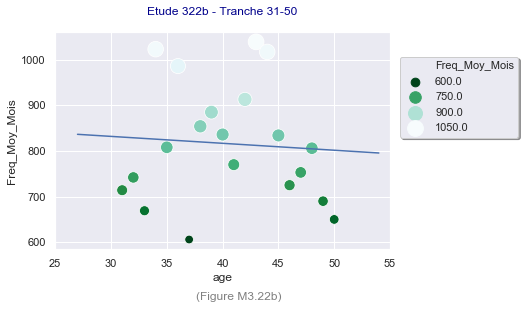

In [22]:
r322b = st.pearsonr(df322b['age'],df322b['Freq_Moy_Mois'])[0]
round(r322b, 3)

# Calcul de la droite de régression linéaire
X = df322b[['age']]
Y = df322b['Freq_Moy_Mois']
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['age'],result.params['intercept']

sns.set()
plt.title("Etude 322b - Tranche 31-50", color='darkblue', y=1.05)

###  SCATTERPLOT 
ax = sns.scatterplot(x=df322b['age'], y=df322b['Freq_Moy_Mois'], 
                size='Freq_Moy_Mois', hue='Freq_Moy_Mois', sizes=(75, 250), palette="BuGn_r", data=df322b)
ax.set_xlim(left=25, right=55)
ax.legend(loc='center right', bbox_to_anchor=(1.4, 0.7), ncol=1, shadow=True)

###  DROITE Régression linéaire
plt.plot(np.arange(27,55),[a*x+b for x in np.arange(27,55)])

plt.figtext(0.45,-0.05,'(Figure M3.22b)', fontsize=12, color = 'gray')
plt.savefig('GRAPHS/figure_M322b.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

- Aucune corrélation ne semble se dessiner sur cette tranches d'age 31-50ans. Valeur du coefficient <b>r322b</b> proche de <b>0</b>.
> **r322b = -0.069**

- Tranche 51+

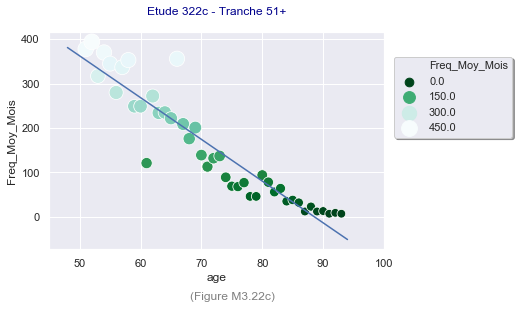

In [23]:
r322c = st.pearsonr(df322c['age'],df322c['Freq_Moy_Mois'])[0]
round(r322c, 3)

# Calcul de la droite de régression linéaire
X = df322c[['age']]
Y = df322c['Freq_Moy_Mois']
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['age'],result.params['intercept']

sns.set()
plt.title("Etude 322c - Tranche 51+", color='darkblue', y=1.05)

###  SCATTERPLOT 
ax = sns.scatterplot(x=df322c['age'], y=df322c['Freq_Moy_Mois'], 
                size='Freq_Moy_Mois', hue='Freq_Moy_Mois', sizes=(75, 250), palette="BuGn_r", data=df322c)
ax.set_xlim(left=45, right=100)
ax.legend(loc='center right', bbox_to_anchor=(1.4, 0.7), ncol=1, shadow=True)
###  DROITE Régression linéaire
plt.plot(np.arange(48,95),[a*x+b for x in np.arange(48,95)])

plt.figtext(0.45,-0.05,'(Figure M3.22c)', fontsize=12, color = 'gray')
plt.savefig('GRAPHS/figure_M322c.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

- Forte corrélation linéaire pour la tranche d'age 51+. Valeur du coefficient <b>r322b</b> proche de <b>-1</b>.
> **r322b = -0.937**

<hr style="height: 1px; color: #839D2D; width: 100%; ">
<balise id="par323"> </balise>  

### <font color='#61210B'>(3.2.3) Corrélation entre l'âge des clients et : </font> la taille du panier moyen (en nombre d’articles) <a href="#home">(↑)</a>    

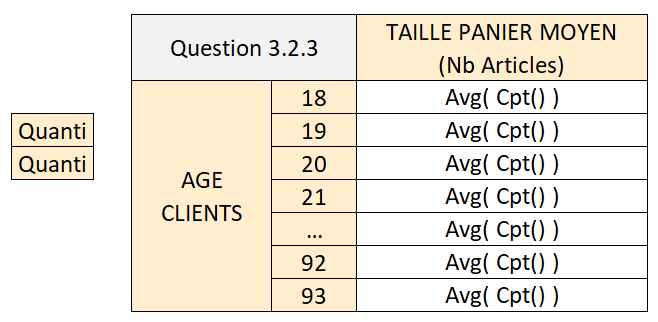

###  <font color='darkblue'>Utilisation de Coefficient de corrélation linéaire :</font>   Formule de Calcul et Interprétation  

Voir cas précédent (3.2.1)  pour principe de fonctionnement et règles.

#### <font color='darkred'>Constitution d'un Dataframe pour analyser les deux variables  
    
* 1°)  Compter le nombre d'article par panier :  Soit <-> nombre de produits par sessions_id/client  

* 2°)  Faire la moyenne par "age" du nombre d'articles



In [24]:
# On calcule le nb d'articles commandés par panier 
df323 = sal[['session_id', 'client', 'age', 'tranche', 'prod', 'price', 'session_date']].copy()
df323 = df323.groupby(['session_id', 'client', 'age', 'tranche'])['prod'].count().reset_index()
df323.head()

,session_id,client,age,tranche,prod
0,s_1,c_329,55,51+,1
1,s_10,c_2218,52,51+,1
2,s_100,c_3854,44,31-50,2
3,s_1000,c_1014,33,31-50,4
4,s_10000,c_476,33,31-50,3


In [25]:
df323 = df323.groupby(['age', 'tranche'])['prod'].mean().reset_index()
df323.head()

,age,tranche,prod
0,19,19-30,1.724901
1,19,31-50,NaN
2,19,51+,NaN
3,20,19-30,1.742947
4,20,31-50,NaN


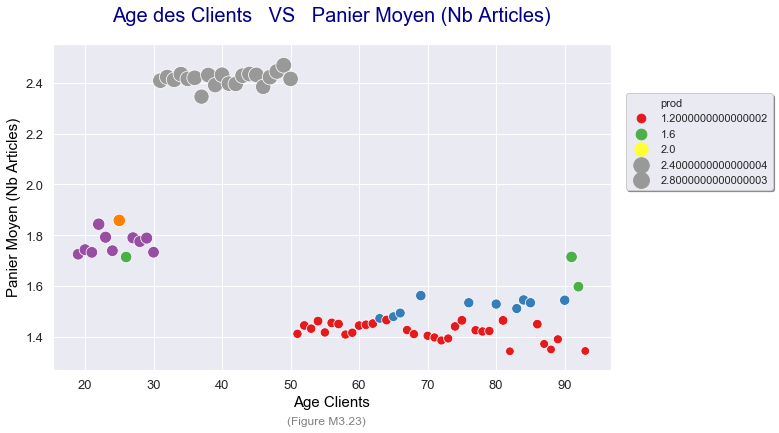

In [26]:
# Calcul de la droite de régression linéaire
X = df323[['age']]
Y = df323['prod']
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['age'],result.params['intercept']

sns.set()
# GRAPHE Panier Moyen
plt.figure(figsize=(10,6))
plt.title("Age des Clients   VS   Panier Moyen (Nb Articles)", fontsize=20, color='darkblue', y=1.05)

ax = sns.scatterplot(x=df323['age'], y=df323['prod'],                                               # palette="Set2"
                size='prod', hue='prod', sizes=(75, 250), palette="Set1", legend='brief', data=df323)  
ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.7), ncol=1, shadow=True)

plt.xlabel("Age Clients", color="black", size=15)
plt.xticks(size=13)
plt.ylabel("Panier Moyen (Nb Articles)", color="black", size=15)
plt.yticks(size=13)

###  DROITE Régression linéaire
plt.plot(np.arange(18,93),[a*x+b for x in np.arange(18,93)])

plt.figtext(0.45, 0 ,'(Figure M3.23)', fontsize=12, color = 'gray')
plt.savefig('GRAPHS/figure_M323.png', dpi=100, bbox_inches='tight')

plt.show()
plt.close()

On voit clairement se distinguer 3 zones de corrélations possibles entre les données.  
Ainsi si nous faisions une approche par tranche d'age <b>("18-30ans"  / "31-50ans"  / "51+")</b> nous verrions certainement apparaitre trois corrélations marquées pour ces tranches d'age avec le panier moyen.
    

#### Split en 3 tranches d'age pour observation :
- 18-30ans
- 31-50ans
- 51+

In [27]:
df323a = df323[df323['tranche']=='19-30'][['age', 'prod']].dropna()
df323b = df323[df323['tranche']=='31-50'][['age', 'prod']].dropna()
df323c = df323[df323['tranche']=='51+'][['age', 'prod']].dropna()

r323a = st.pearsonr(df323a['age'],df323a['prod'])[0]
r323b = st.pearsonr(df323b['age'],df323b['prod'])[0]
r323b = st.pearsonr(df323c['age'],df323c['prod'])[0]

- Tranche 18-30ans

Pas de corrélation linéaire pour cette tranche. Valeur du coefficient <b>r323a</b> proche de <b>0</b>.
> **r323a = 0.11**

En revanche, une faible varation du panier moyen autour de 1.76 articles est à noter

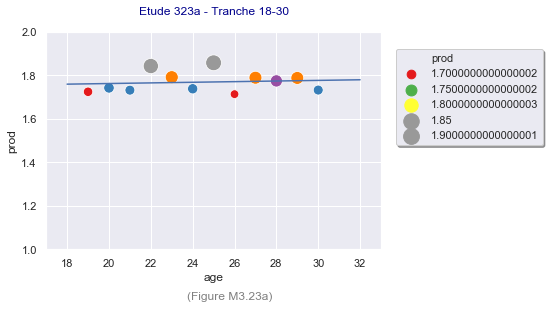

In [28]:
# Calcul de la droite de régression linéaire
X = df323a[['age']]
Y = df323a['prod']
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['age'],result.params['intercept']

# GRAPHE Panier Moyen
sns.set()
plt.title("Etude 323a - Tranche 18-30", color='darkblue', y=1.05)

ax = sns.scatterplot(x=df323a['age'], y=df323a['prod'],          
                size='prod', hue='prod', sizes=(75, 250), palette="Set1", legend='brief', data=df323a)  
ax.set_xlim(left=17, right=33)
ax.set_ylim(1, 2)
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.7), ncol=1, shadow=True)
###  DROITE Régression linéaire
plt.plot(np.arange(18,33),[a*x+b for x in np.arange(18,33)])

plt.figtext(0.45, -0.05 ,'(Figure M3.23a)', fontsize=12, color = 'gray')
plt.savefig('GRAPHS/figure_M323a.png', dpi=100, bbox_inches='tight')

plt.show()
plt.close()

- Tranche 31-50ans

Pas de corrélation linéaire pour cette tranche. Valeur du coefficient <b>r323b</b> proche de <b>0</b>.
> <b>r323b = 0.278</b>

En revanche, une faible varation du panier moyen autour de 2.42 articles est à noter

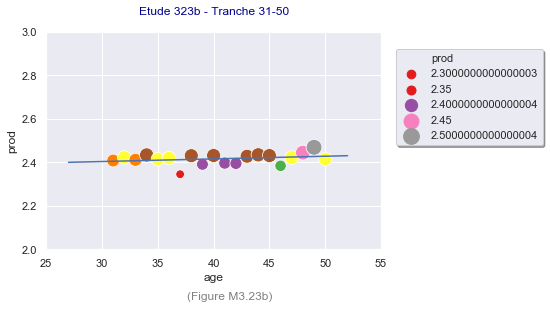

In [29]:
r323b = st.pearsonr(df323b['age'],df323b['prod'])[0]
round(r323b, 3)

# Calcul de la droite de régression linéaire
X = df323b[['age']]
Y = df323b['prod']
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['age'],result.params['intercept']

# GRAPHE Panier Moyen
sns.set()
plt.title("Etude 323b - Tranche 31-50", color='darkblue', y=1.05)

ax = sns.scatterplot(x=df323b['age'], y=df323b['prod'],          
                size='prod', hue='prod', sizes=(75, 250), palette="Set1", legend='brief', data=df323b)  
ax.set_xlim(left=25, right=55)
ax.set_ylim(2, 3)
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.7), ncol=1, shadow=True)
###  DROITE Régression linéaire
plt.plot(np.arange(27,53),[a*x+b for x in np.arange(27,53)])

plt.figtext(0.45, -0.05 ,'(Figure M3.23b)', fontsize=12, color = 'gray')
plt.savefig('GRAPHS/figure_M323b.png', dpi=100, bbox_inches='tight')

plt.show()
plt.close()

- Tranche 51+

Pas de corrélation linéaire pour cette tranche. Valeur du coefficient <b>r323c</b> proche de <b>0</b>.
> <b>r323c = 0.212</b>

En revanche, une faible varation du panier moyen autour de 1.45 articles est à noter

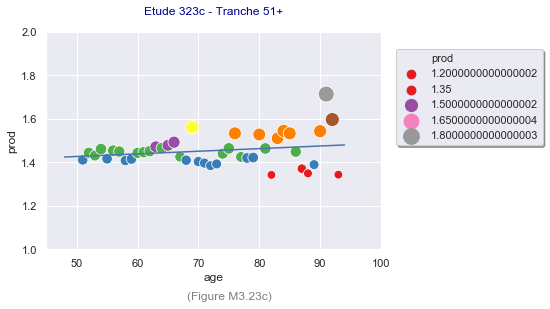

In [30]:
r323c = st.pearsonr(df323c['age'],df323c['prod'])[0]
round(r323c, 3)

# Calcul de la droite de régression linéaire
X = df323c[['age']]
Y = df323c['prod']
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['age'],result.params['intercept']

# GRAPHE Panier Moyen
sns.set()
plt.title("Etude 323c - Tranche 51+", color='darkblue', y=1.05)

ax = sns.scatterplot(x=df323c['age'], y=df323c['prod'],          
                size='prod', hue='prod', sizes=(75, 250), palette="Set1", legend='brief', data=df323c)  
ax.set_xlim(left=45, right=100)
ax.set_ylim(1, 2)
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.7), ncol=1, shadow=True)
###  DROITE Régression linéaire
plt.plot(np.arange(48,95),[a*x+b for x in np.arange(48,95)])

plt.figtext(0.45, -0.05 ,'(Figure M3.23c)', fontsize=12, color = 'gray')
plt.savefig('GRAPHS/figure_M323c.png', dpi=100, bbox_inches='tight')

plt.show()
plt.close()

<hr style="height: 1px; color: #839D2D; width: 100%; ">
<balise id="par324"> </balise>  

### <font color='#61210B'>(3.2.4) Corrélation entre l'âge des clients et : </font> les catégories de produits achetés  <a href="#home">(↑)</a>    

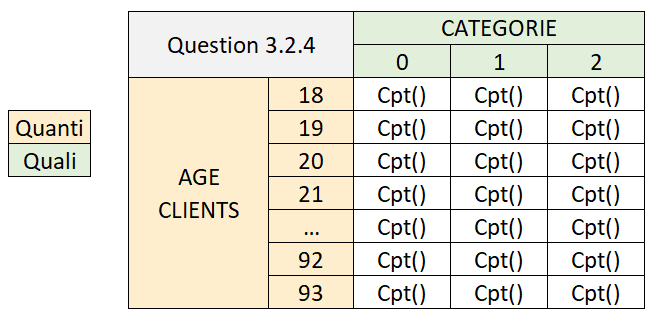

###  <font color='darkblue'>Utilisation d'ANOVA :</font>   Formule de Calcul et Interprétation  


- Le test <b>d'ANOVA</b> (analyse de la variance) ou <b>eta² (η²)</b> permet de savoir si une donnée qualitative et une donnée quantitative sont corrélées.   
Le résultat obtenu est compris entre <b>0</b> et <b>1</b>. Plus il est proche de 1 plus les données sont corrélées..
> 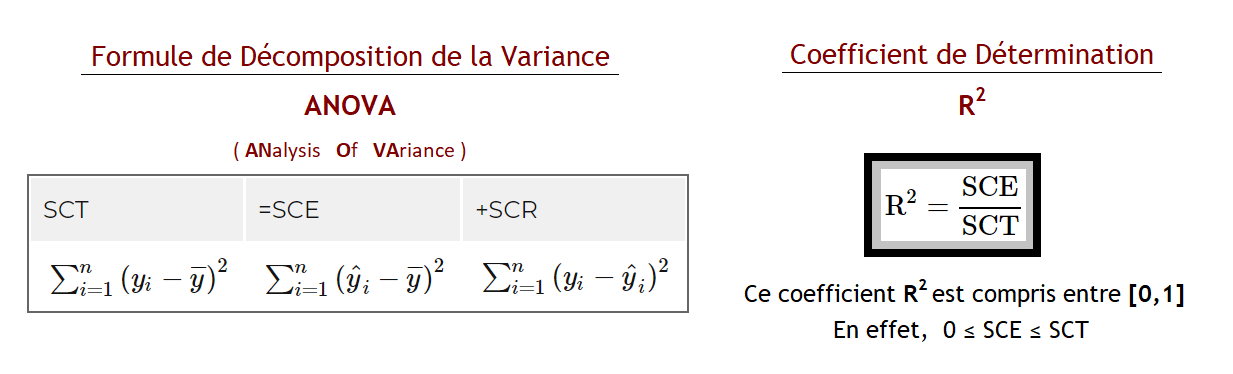

* SCT (Somme des Carrés Totale) traduit la variation totale de Y.  
* SCE (Somme des Carrés Expliquée) traduit la variation expliquée par le modèle.  
* SCR (Somme des Carrés Résiduelle) traduit la variation inexpliquée par le modèle.  
  

Si R²=1 , on a alors SCE=SCT : toute la variation est expliquée par le modèle.  
Si R²=0 , on a alors SCR=SCT : aucune variation n'est expliquée par le modèle.

  
Dans le cas de la régression linéaire simple, on obtient :  
> R² = r²(X,Y)  

où r(X,Y) est la corrélation linéaire (empirique) entre X et Y .


In [31]:
df324 = sal[['age', 'categ', 'client']].copy()
df324.head()

,age,categ,client
0,45,0,c_4450
1,41,0,c_5433
2,37,0,c_857
3,33,0,c_3679
4,47,0,c_868


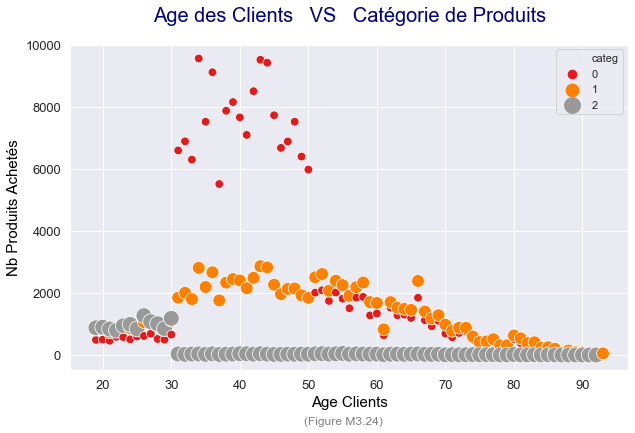

In [32]:
df = sal.groupby(['age', 'categ'])['prod'].size().reset_index(name='counts')                                                       

plt.figure(figsize=(10,6))
sns.scatterplot(x=df['age'], y=df['counts'],                                             
                size='categ', hue='categ', sizes=(75, 250), palette="Set1", legend='brief', data=df)
plt.title("Age des Clients   VS   Catégorie de Produits", fontsize=20, color='darkblue', y=1.05)
plt.xlabel("Age Clients", color="black", size=15)
plt.xticks(size=13)
plt.ylabel("Nb Produits Achetés", color="black", size=15)
plt.yticks(size=13)

plt.figtext(0.45, 0 ,'(Figure M3.24)', fontsize=12, color = 'gray')
plt.savefig('GRAPHS/figure_M324.png', dpi=100, bbox_inches='tight')

plt.show()
plt.close()

In [33]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

# Calcul eta^2 
round(eta_squared(df324['categ'],df324['age']), 3)

0.099

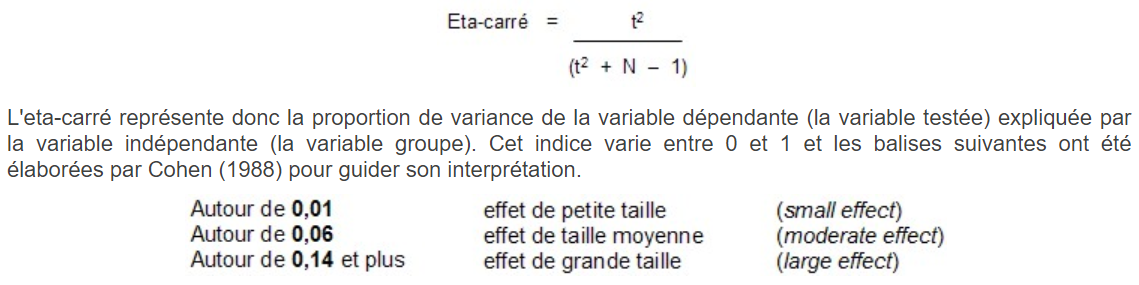

> ### <font color='darkred'>Dans notre test de corrélation entre l'âge et la catégorie de produit acheté, nous obtenons un résultat de 0.099
### Ceci nous montre que les données  sont assez corrélées.  
> ### L'âge des clients a donc une influence sur la catégorie de produits achetés.


### Vérifions avec le calcul du F de fisher et sa p-value associée
#### Principe : nous pouvons dire qu'il y a une forte corrélation entre une variable qualitative et d'autres variables, si le test ANOVA nous donne une grande valeur de test F(fisher) et une petite valeur pour la p-value


In [34]:
F, p = st.f_oneway(df324['age'], df324['categ'])
print("F de fisher = ", F)
print("p-value associée = ", p)

F de fisher =  3388994.52102057
p-value associée =  0.0


### <font color='darkblue'>ILLUSTRATION :  Graphes par Catégories

In [35]:
df324 = sal[['age', 'categ', 'client']].copy()
df324 = df324.pivot_table(index=['age'], columns=['categ'], values=['client'], aggfunc='count').reset_index()
df324.columns = ['Age', 'Categ_0', 'Categ_1', 'Categ_2']
df324.head()

,Age,Categ_0,Categ_1,Categ_2
0,19,488.0,817.0,877.0
1,20,498.0,830.0,896.0
2,21,461.0,732.0,839.0
3,22,587.0,791.0,797.0
4,23,575.0,919.0,943.0


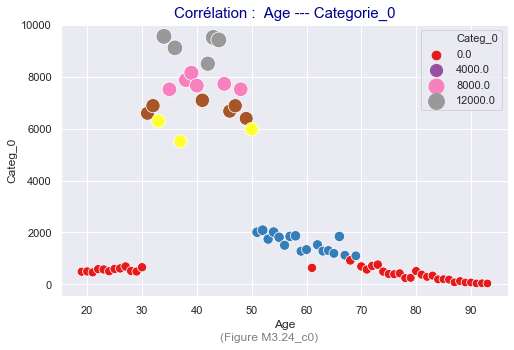

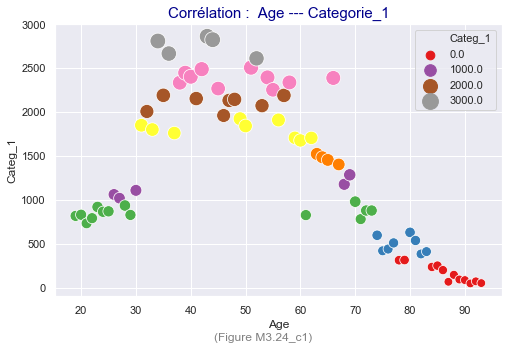

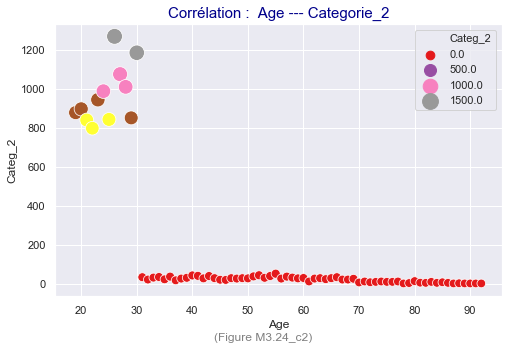

In [36]:
fig = plt.figure(figsize=(8,5))
sns.scatterplot(x=df324['Age'], y=df324['Categ_0'],                                             
                size='Categ_0', hue='Categ_0', sizes=(75, 250), palette="Set1", legend='brief', data=df324)
plt.title("Corrélation :  Age --- Categorie_0", fontsize=15, color='darkblue')
plt.figtext(0.4, 0 ,'(Figure M3.24_c0)', fontsize=12, color = 'gray')
plt.savefig('GRAPHS/figure_M324_categ0.png', dpi=100, bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(8,5))
sns.scatterplot(x=df324['Age'], y=df324['Categ_1'],
                size='Categ_1', hue='Categ_1', sizes=(75, 250), palette="Set1", legend='brief', data=df324)
plt.title("Corrélation :  Age --- Categorie_1", fontsize=15, color='darkblue')
plt.figtext(0.4, 0 ,'(Figure M3.24_c1)', fontsize=12, color = 'gray')
plt.savefig('GRAPHS/figure_M324_categ1.png', dpi=100, bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(8,5))
sns.scatterplot(x=df324['Age'], y=df324['Categ_2'],
                size='Categ_2', hue='Categ_2', sizes=(75, 250), palette="Set1", legend='brief', data=df324)
plt.title("Corrélation :  Age --- Categorie_2", fontsize=15, color='darkblue')
plt.figtext(0.4, 0 ,'(Figure M3.24_c2)', fontsize=12, color = 'gray')
plt.savefig('GRAPHS/figure_M324_categ2.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

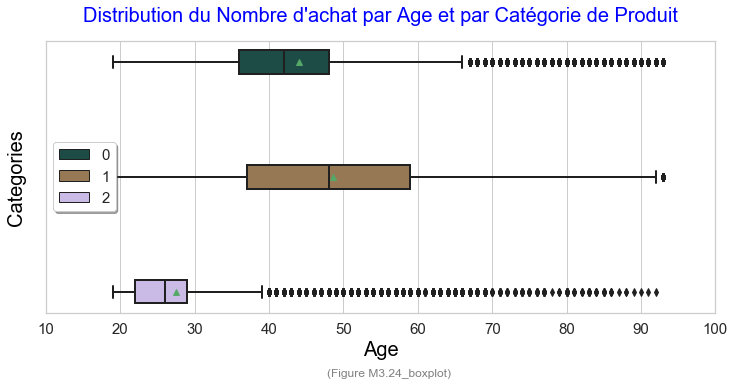

,age_0,categ_0,age_1,categ_1,age_2,categ_2
count,193602.000000,193602.0,99866.000000,99866.0,12835.000000,12835.0
mean,44.022154,0.0,48.637524,1.0,27.515232,2.0
std,11.309410,0.0,15.211421,0.0,9.854583,0.0
min,19.000000,0.0,19.000000,1.0,19.000000,2.0
25%,36.000000,0.0,37.000000,1.0,22.000000,2.0
50%,42.000000,0.0,48.000000,1.0,26.000000,2.0
75%,48.000000,0.0,59.000000,1.0,29.000000,2.0
max,93.000000,0.0,93.000000,1.0,92.000000,2.0


In [37]:
df324a = sal[['age', 'categ']].copy()
df324a = df324a.sort_values(['age', 'categ'])
y = df324a['age']
x = df324a['categ']

sns.set(style="whitegrid")
fig = plt.figure(figsize=(12,5))
ax = sns.boxplot(y, x, data=df324a, hue=x, orient="h", showmeans=True, linewidth=2, palette='cubehelix')  ## showfliers=False
ax.set_xlim(left=10, right=100)

# TITRE GRAPHE 
plt.title("Distribution du Nombre d'achat par Age et par Catégorie de Produit", fontsize=20, color = 'Blue', y=1.05)
ax.legend(fontsize=15, loc='center left', shadow=True)

# Libellé Abscisse (x)
plt.xticks(size=15)
plt.xlabel("Age", color='black', size=20) 
# Libellé Ordonnée (y)
plt.yticks(color="white")
plt.ylabel("Categories", color="black", size=20, rotation=90)
plt.figtext(0.45, -0.05 ,'(Figure M3.24_boxplot)', fontsize=12, color = 'gray')
plt.savefig('GRAPHS/figure_M324_boxplot.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

df324a1 = df324a[df324a['categ']==0].describe(include="all")
df324a2 = df324a[df324a['categ']==1].describe(include="all")
df324a3 = df324a[df324a['categ']==2].describe(include="all")
df324result = pd.concat([pd.concat([df324a1, df324a2], axis=1, join='inner'), df324a3], axis=1, join='inner')
df324result.columns = ['age_0', 'categ_0', 'age_1', 'categ_1', 'age_2', 'categ_2']
df324result

In [38]:
dureetotale = round(time.time() - trt_start_time, 5)
print("--- Durée TOTALE du Notebook PJ4 Mission 3 --- ", "%s seconds" % dureetotale)

--- Durée TOTALE du Notebook PJ4 Mission 3 ---  8.66059 seconds
